<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Marianna Abbattista](https://github.com/Mariabba), [Eleonora Cocciu](https://github.com/eleonoracocciu) and [Dafina Leva](https://github.com/dafina-95)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 20/11/2020<b>

In [11127]:
%matplotlib inline

# general libraries
import os
import sys
import math
import statistics
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import defaultdict

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# scipy libraries
from scipy.stats import pearsonr

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

In [11128]:
data_directory = "../../data/"
plot_directory = "../../plots/DataUnderstanding/"
TR_file = data_directory + "Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Test_HR_Employee_Attrition.csv"

<h1> Data understanding </h1>

In [11129]:
df = pd.read_csv(TR_file, sep=",") 

In [11130]:
df.head()  # first rows sneak peek

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,52.00,No,Travel_Rarely,593,Research & Development,9,4,Medical,2,Male,...,3,80.00,0,20,2.00,2,8.00,7,2,13
1,36.00,No,Travel_Rarely,1218,Research & Development,1,1,Life Sciences,2,Male,...,3,80.00,1,21,3.00,3,1.00,8,1,6
2,nan,No,Travel_Frequently,530,Sales,16,3,Life Sciences,3,NaN,...,3,nan,1,7,4.00,3,1.00,5,1,2
3,33.00,No,Travel_Rarely,953,Research & Development,5,4,Technical Degree,2,Male,...,2,nan,0,12,1.00,3,3.00,7,0,7
4,nan,No,Travel_Rarely,1380,Research & Development,9,2,Life Sciences,3,Female,...,3,80.00,0,2,nan,3,10.00,2,2,1


<h6> Columns' data type and number of non-null elements identification </h6>

In [11131]:
df.info() # DataFrame's summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1000 non-null   float64
 1   Attrition                 1176 non-null   object 
 2   BusinessTravel            1069 non-null   object 
 3   DailyRate                 1176 non-null   int64  
 4   Department                1176 non-null   object 
 5   DistanceFromHome          1176 non-null   int64  
 6   Education                 1176 non-null   int64  
 7   EducationField            1176 non-null   object 
 8   EnvironmentSatisfaction   1176 non-null   int64  
 9   Gender                    1117 non-null   object 
 10  HourlyRate                1176 non-null   int64  
 11  JobInvolvement            1176 non-null   int64  
 12  JobLevel                  1176 non-null   int64  
 13  JobRole                   1176 non-null   object 
 14  JobSatis

Our dataframe contains 33 columns and 1175 rows. The following 8 columns have <b>missing values</b>:
- Age;
- BusinessTravel;
- Gender;
- MonthlyIncome;
- Over18;
- PerformanceRating;
- StandardHours;
- TrainingTimesLastYear. 

The missing values will be replaced in section <b>Missing data imputation</b>. 

Since all 9 objects columns are <b>nominal/ordinal attributes</b>, they must be converted to integer values:
- Attrition;
- BusinessTravel;
- Department;
- EducationField;
- Gender;
- JobRole;
- MaritalStatus;
- Over18;
- OverTime.

The categorical/ordinal attributes will be encoded in section <b>Type conversion (Part 1)</b>.

All 6 float64 columns have <b>misinterpreted data types</b> (ideally, it's better to express thems as int64):
- Age;
- MonthlyIncome;
- PerformanceRating;
- StandardHours;
- TrainingTimesLastYear
- YearsAtCompany.

The misinterpreted data types will be converted in section <b>Type conversion (Part 2)</b>.

We will see that some columns are non meaningful to our analysis in section <b>Dimensionality Reduction (Part 1)</b> and others are correlated among them, as described in section <b>Dimensionality Reduction (Part 2)</b>.
    
Finally, we will perform discretisation on some of our numerical features in section <b>Data discretisation </b> and we will extract some additional and useful features in section <b>Additional feature extraction</b>.

<h6>Graphical visualize null values</h6>

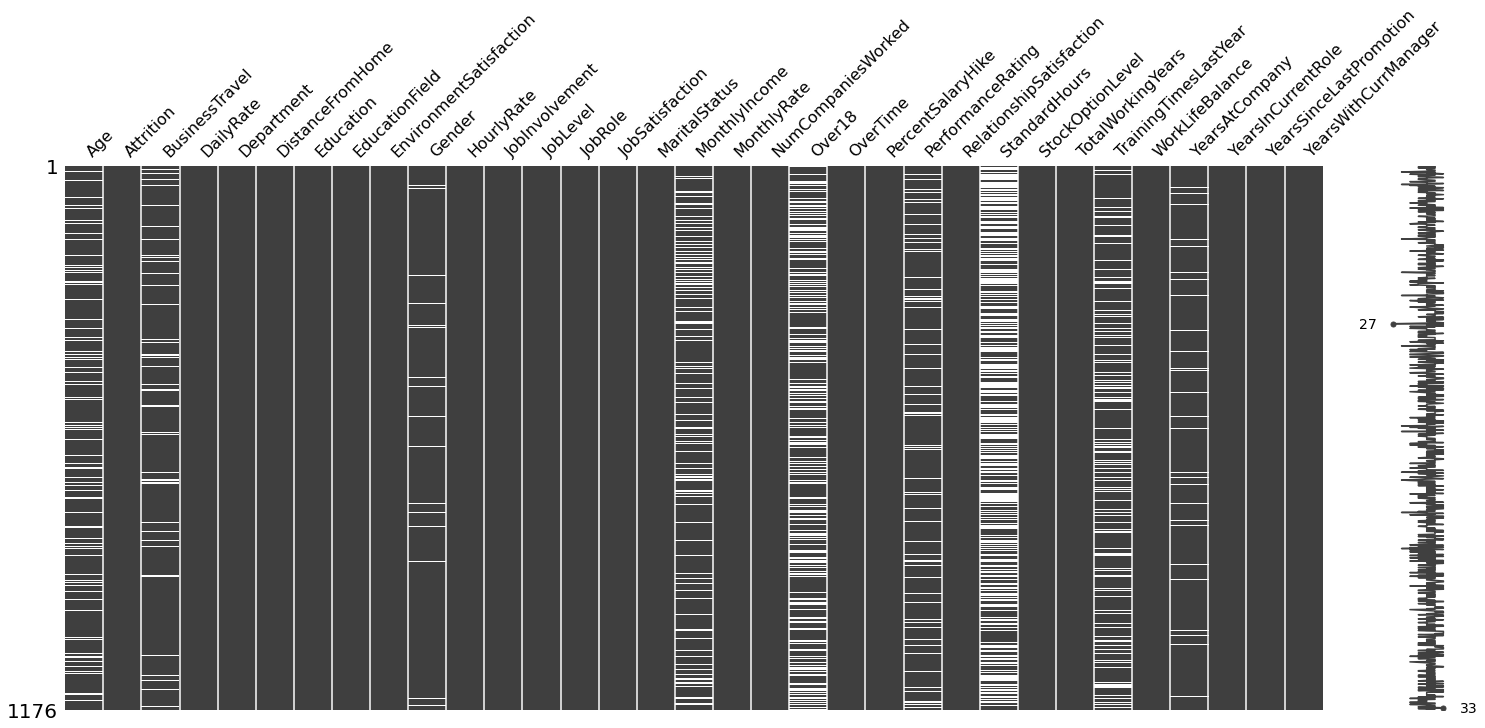

In [11132]:
msno.matrix(df)

The <b>missingno library</b> confirms that our dataset has the above 9 missing features.

<h2> New feature extraction</h2>

Often, the input features for a predictive modeling task interact in unexpected. For example, it is common to add new variables that represent the interaction between given features, e.g a new column that represents one variable multiplied by another.

In our dataset we consider meanigful the addition of the following features:
- <b>OverallSatisfaction</b>, expressed as:
$$\dfrac{EnvironmentSatisfaction + JobInvolvement + JobSatisfaction + RelationshipSatisfaction + WorkLifeBalance}{N}$$
- <b>TaxRate</b>, expressed as:
$$\dfrac{MonthlyRate - MonthlyIncome}{MonthlyRate} $$

In [11133]:
# insert new feature "OverallSatisfaction"
last_column_index = df.columns.get_loc("YearsWithCurrManager")
data = []
for row in df[["EnvironmentSatisfaction", "JobInvolvement", "JobSatisfaction","RelationshipSatisfaction",
        "WorkLifeBalance"]].itertuples():
    tmp_list = []
    tmp_list.append(row.EnvironmentSatisfaction)
    tmp_list.append(row.JobInvolvement)
    tmp_list.append(row.JobSatisfaction)
    tmp_list.append(row.RelationshipSatisfaction)
    tmp_list.append(row.WorkLifeBalance)
    data.append(math.floor(np.mean(tmp_list)))  # rounded down

df.insert(last_column_index, 'OverallSatisfaction', data)
df.shape

(1176, 34)

In [11134]:
# insert new feature "TaxRate"
last_column_index = df.columns.get_loc("OverallSatisfaction")
data = []
for row in df.itertuples():
    tax_rate = ((row.MonthlyRate - row.MonthlyIncome) / row.MonthlyRate)
    try:
        computed_income_floor = math.floor(row.MonthlyRate - row.MonthlyRate*tax_rate)
        computed_income_ceil = math.ceil(row.MonthlyRate - row.MonthlyRate*tax_rate)
        if computed_income_floor == row.MonthlyIncome or computed_income_ceil == row.MonthlyIncome:
            data.append(round(tax_rate, 2))  # abs
        else:
            print("error")
            sys.exit(-1)
    except ValueError:  # omitt NaN values
        data.append(np.NaN) 

df.insert(last_column_index, 'TaxRate', data)
df.shape

(1176, 35)

By adding the additional feature TaxRate, we notice that some taxes have a negative value, which is explained due to the presence of records having MonthlyIncome > MonthlyRate. We will try to solve this problem in section <b> Inconsistent values elimination </b>.

<h6> Rows that contain duplicate data identification </h6>

In [11135]:
# calculate duplicated rows
dups = df.duplicated()
# report if there are any duplicates
print("Duplicate rows = ", dups.any(), sep="\t")

# list all duplicate rows
# print(df[dups])

# delete duplicate rows
# df.drop_duplicates(inplace=True)

Duplicate rows = 	False


<h6>Inconsistent values elimination</h6>

We notice that in our dataset some records have unconstrained records, such as rows having:
- <b>MonthlyIncome < DailyRate</b>;
- <b>Age - TotalworkingYears < 16</b>;
- <b>Age - YearsAtCompany < 16</b>;
- <b>TotalworkingYears < YearsAtCompany</b>;
- <b>YearsInCurrentRole < YearsSinceLastPromotion</b>;
- <b>YearsAtCompany < YearsInCurrentRole</b> and <b>NumCompaniesWorked = 0</b>;
- <b>YearsAtCompany < YearsSinceLastPromotion</b> and <b>NumCompaniesWorked = 0</b>;
- <b>YearsAtCompany < YearsWithCurrManager</b>;
- <b>MonthlyRate < MonthlyIncome</b>.
    
We think the above records are incosistent, since:
- MonthlyIncome is the result of DailyRate multiplies by the number of working days in a month, from which is subtracted taxes and additional levies. For this reason ideally MonthlyIncome must be greater than DailyRate;
- stating IBM's policies (https://www.ibm.com/ibm/responsibility/policy11.shtml), the company doesn't use child labor, where the term "child" refers to any employed person under the age of 16;
- for the same reason of above, an employee can't work in the current company under the age of 16;
- ideally, an employee's years at company counts his contract working years at the company, so this value has to be smaller or equal the total number of his working years;
- years since last promotion must be at least equal to the years in current job, smaller if in the promotion years are counted jobrole's advancement levels;
- if an employee is in his current jobrole more years than he is working in the current company, he must had worked at least in a previous company;
- if last employee's promotion is elder than his working yearst at the current company, he must had worked at least in a previous company;
- an employee's years with current manager must be within his working years at the current company;
- since "MonthlyIncome" equals the net income and "MonthlyRate" equals the groos income, the first must be smaller  the second.
    
For the above mentioned reasons, we will drop some of the above inconsistent records or features.

In [11136]:
def get_pearson_correlation_coefficient(column_name1, column_name2):
    # normalized values received as input
    x = df[[column_name1]].fillna(0)
    y = df[[column_name2]].fillna(0)
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)[:, 0]
    y_scaled = min_max_scaler.fit_transform(y)[:, 0]

    corr, _ = pearsonr(x_scaled, y_scaled)
    return corr

In [11137]:
def get_age_difference(column_name2):
    column_index = list(df.columns).index(column_name2)
    tmp_list = []
    i = 0
    for row in df[["Age", column_name2]].itertuples():
        if row.Age - df.iloc[i, column_index] < 16:
            tmp_list.append(i)
        i += 1
    return tmp_list

In [11138]:
def get_column1_greater_than_column2_difference(column_name1, column_name2):
    column1_index = list(df.columns).index(column_name1)
    column2_index = list(df.columns).index(column_name2)
    tmp_list = []
    for i in df.index[df[column_name1] > df[column_name2]]:
        tmp_list.append(df.iloc[i, column1_index] - df.iloc[i, column2_index])
    return tmp_list

In [11139]:
print("Age < TotalWorkingYears: ", len(get_age_difference("TotalWorkingYears")))
print("Age < YearsAtCompany: ", len(get_age_difference("YearsAtCompany")))
print("Age < YearsInCurrentRole: ", len(get_age_difference("YearsInCurrentRole")))
print("Age < YearsSinceLastPromotion: ", len(get_age_difference("YearsSinceLastPromotion")))
print("Age < YearsWithCurrManager: ", len(get_age_difference("YearsWithCurrManager")))

Age < TotalWorkingYears:  154
Age < YearsAtCompany:  0
Age < YearsInCurrentRole:  24
Age < YearsSinceLastPromotion:  10
Age < YearsWithCurrManager:  20


In [11140]:
print("YearsInCurrentRole > TotalWorkingYears: ", len(get_column1_greater_than_column2_difference(
                                                                  "YearsInCurrentRole", "TotalWorkingYears")))
print("YearsAtCompany > TotalWorkingYears: ", len(get_column1_greater_than_column2_difference(
                                                                    "YearsAtCompany", "TotalWorkingYears")))
print("YearsWithCurrManager > YearsAtCompany: ", len(get_column1_greater_than_column2_difference(
                                                                 "YearsWithCurrManager", "YearsAtCompany")))
print("YearsWithCurrManager > TotalWorkingYears: ", len(get_column1_greater_than_column2_difference(
                                                                 "YearsWithCurrManager", "TotalWorkingYears")))
print("HourlyRate > DailyRate: ", len(get_column1_greater_than_column2_difference(
                                                                                  "HourlyRate", "DailyRate")))
print("HourlyRate > MonthlyRate: ", len(get_column1_greater_than_column2_difference(
                                                                                  "HourlyRate", "MonthlyRate")))
print("HourlyRate > MonthlyIncome: ", len(get_column1_greater_than_column2_difference(
                                                                                "HourlyRate", "MonthlyIncome")))
print("DailyRate > MonthlyRate: ", len(get_column1_greater_than_column2_difference(
                                                                               "DailyRate", "MonthlyRate")))
print("DailyRate > MonthlyIncome: ", len(get_column1_greater_than_column2_difference(
                                                                                  "DailyRate", "MonthlyIncome")))
print("avg DailyRate - MonthlyIncome", np.mean(get_column1_greater_than_column2_difference(
                                                                                  "DailyRate", "MonthlyIncome")))
print("YearsSinceLastPromotion > YearsInCurrentRole: ", len(get_column1_greater_than_column2_difference(
                                                            "YearsSinceLastPromotion",  "YearsInCurrentRole")))
tmp_res = df[(df["YearsInCurrentRole"] > df["YearsAtCompany"]) & (df["NumCompaniesWorked"] == 0)].shape[0]
print("YearsInCurrentRole > YearsAtCompany and NumCompaniesWorked = 0: ", tmp_res)
tmp_res = df[(df["YearsSinceLastPromotion"] > df["YearsAtCompany"]) & (df["NumCompaniesWorked"] == 0)].shape[0]
print("YearsSinceLastPromotion > YearsAtCompany and NumCompaniesWorked = 0: ", tmp_res)

YearsInCurrentRole > TotalWorkingYears:  0
YearsAtCompany > TotalWorkingYears:  321
YearsWithCurrManager > YearsAtCompany:  361
YearsWithCurrManager > TotalWorkingYears:  0
HourlyRate > DailyRate:  0
HourlyRate > MonthlyRate:  0
HourlyRate > MonthlyIncome:  0
DailyRate > MonthlyRate:  0
DailyRate > MonthlyIncome:  1
avg DailyRate - MonthlyIncome 55.0
YearsSinceLastPromotion > YearsInCurrentRole:  125
YearsInCurrentRole > YearsAtCompany and NumCompaniesWorked = 0:  56
YearsSinceLastPromotion > YearsAtCompany and NumCompaniesWorked = 0:  23


In [11141]:
tmp_list = []
for row in df[["DailyRate", "MonthlyIncome"]].itertuples():
    if row.MonthlyIncome > row.DailyRate:
        tmp_list.append(row.MonthlyIncome - row.DailyRate)
print("avg MonthlyIncome - row.DailyRate = ", np.mean(tmp_list))

avg MonthlyIncome - row.DailyRate =  5762.359667359668


By taking into account the validity of "Age" and "YearsAtCompany" features (all records have Age - YearsAtCompany < 16), we can drop the following <b>incosistent features</b>:
- <b>TotalWorkingYears</b>: 154 records have Age - TotalworkingYears < 16 and since 321 additional records have YearsAtCompany > TotalWorkingYears, with an average difference of 6.741 between them, we think "TotalWorkingYears" is a biased feature (too high values in the first case, too small in the second), so we will drop it;
- <b>YearsWithCurrManager</b>:  20 records have Age - YearsWithCurrManager < 16 and 361 record have YearsWithCurrManager > YearsAtCompany, which again we reputate to be semantically wrong.

These two features elimination is justified also by their meaningful positive correlation:
- TotalWorkingYears has a <b>+0.774</b> Pearson Correlation Coefficient with JobLevel;
- YearsWithCurrManager has a <b>+0.711</b> Pearson Correlation Coefficient with YearsInCurrentRole;
    
    
We will drop the following inconsistent records, too:
- 1 record has MonthlyIncome < DailyRate, since their difference is equal to 55 (the average difference between MonthlyIncome and DailyRate is 5762.359 in our Dafadrame);
- 24 records have Age - YearsInCurrentRole < 16;
- 10 records have Age - YearsSinceLastPromotion < 16;
- 56 records have YearsAtCompany < YearsInCurrentRole and NumCompaniesWorked = 0;
- 23 records have YearsAtCompany < YearsSinceLastPromotion and NumCompaniesWorked = 0;
- 125 records have YearsInCurrentRole < YearsSinceLastPromotion.

In [11142]:
print('Pearsons correlation: %.3f' % get_pearson_correlation_coefficient("TotalWorkingYears", 
                                                                                         "JobLevel"))

Pearsons correlation: 0.774


In [11143]:
print('Pearsons correlation: %.3f' % get_pearson_correlation_coefficient("YearsWithCurrManager", 
                                                                                         "YearsInCurrentRole"))

Pearsons correlation: 0.711


In [11144]:
# remove incosistent features
del df["TotalWorkingYears"]
del df["YearsWithCurrManager"]

# remove incosistent records
to_drop_indexes = set()

to_drop_indexes = to_drop_indexes.union(set(list(df.index[df["DailyRate"] > df["MonthlyIncome"]])))
to_drop_indexes = to_drop_indexes.union(set(get_age_difference("YearsInCurrentRole")))
to_drop_indexes = to_drop_indexes.union(set(get_age_difference("YearsSinceLastPromotion")))
to_drop_indexes = to_drop_indexes.union(set(list(df.index[df["YearsSinceLastPromotion"] > df["YearsInCurrentRole"]])))
tmp_list = df.index[(df["YearsInCurrentRole"] > df["YearsAtCompany"]) & (df["NumCompaniesWorked"] == 0)]
to_drop_indexes = to_drop_indexes.union(set(tmp_list))
tmp_list = df.index[(df["YearsSinceLastPromotion"] > df["YearsAtCompany"]) & (df["NumCompaniesWorked"] == 0)]
to_drop_indexes = to_drop_indexes.union(set(tmp_list))

df.drop(list(to_drop_indexes), axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
print("dropped rows = ", len(to_drop_indexes), sep="\t")
df.shape

dropped rows = 	194


(982, 33)

Our record cleaning process removed <b>194 baised records</b> and <b> 2 biased features</b> (45 records had two or more unsatisfied constrains).

Finally, we have 161 records where MonthlyRate <= MonthlyIncome. Since the two feature's name start both with "Month", we think are part of a type error. To avalorate our intuition we compare these baised taxrates with the ones of similar records (by taking records with same JobRole and JobLevel as the biased ones, we were able to find at least one similar record for all of them):

In [11145]:
def get_neighbours_taxrate(jobRole, jobLevel):
    tmp_df = df[(df["JobRole"] == jobRole) & (df["JobLevel"] == jobLevel)]
    taxes = []
    
    for row in tmp_df.itertuples():
        if row.MonthlyRate > row.MonthlyIncome:
            taxes.append(row.TaxRate)
    return taxes

In [11146]:
# remove inconsistent switched records
to_drop_indexes = set()
i = 0   
for row in df.itertuples():
    if row.MonthlyIncome >= row.MonthlyRate:
        neighbours_taxrate = get_neighbours_taxrate(row.JobRole, row.JobLevel)

        if len(neighbours_taxrate) == 0:
            print(row.JobRole, row.JobLevel)
        else:
            curr_taxrate = abs(row.TaxRate)
            if curr_taxrate in neighbours_taxrate:
                continue
            else:
                cut_off = np.std(neighbours_taxrate)
                n_max = max(neighbours_taxrate) + cut_off
                n_min = min(neighbours_taxrate) - cut_off
                if curr_taxrate < n_min or curr_taxrate > n_max:
                    # if np.std([curr_taxrate] + neighbours_taxrate) > 0.3:
                    to_drop_indexes.add(i) 
    i += 1
                
df.drop(list(to_drop_indexes), axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
print("dropped rows = ", len(to_drop_indexes), sep="\t")
df.shape

dropped rows = 	41


(941, 33)

In [11147]:
index1 = df.columns.get_loc("MonthlyIncome")
index2 = df.columns.get_loc("MonthlyRate")
index3 = df.columns.get_loc("TaxRate")

# switch biased records 
data1 = []
data2 = []
for row in df.itertuples():
    if row.MonthlyIncome > row.MonthlyRate:
        data1.append(row.MonthlyRate)
        data2.append(row.MonthlyIncome)
    else:
        data1.append(row.MonthlyIncome)
        data2.append(row.MonthlyRate)

# correct TaxRate feature 
data3 = []
for i in range(0, len(data1)):
    tax_rate = ((data2[i] - data1[i]) / data2[i])
    try:
        computed_income_floor = math.floor(data2[i] - data2[i]*tax_rate)
        computed_income_ceil = math.ceil(data2[i] - data2[i]*tax_rate)
        if computed_income_floor == data1[i] or computed_income_ceil == data1[i]:
            data3.append(round(tax_rate, 2))  
        else:
            print("error")
            sys.exit(-1)
    except ValueError:  # omitt NaN values
        data3.append(np.NaN) 

del df["MonthlyIncome"]
del df["MonthlyRate"]
del df["TaxRate"]

df.insert(index1, 'MonthlyIncome', data1)
df.insert(index2, 'MonthlyRate', data2)
df.insert(index3, 'TaxRate', data3)
df.shape

(941, 33)

In [11148]:
df[df["MonthlyIncome"] > df["MonthlyRate"]].shape[0]

0

In [11149]:
df[df["TaxRate"] < 0].shape[0]

0

In [11150]:
df["MonthlyIncome"].isna().sum()

166

In order to establish if the switch among the features had occurred, we measured the standard deviation of neighbours' TaxRates. With it we establishing a cut-off above and below the maximum and minumn neighbours' TaxRates, respectively. In this way, we <b>dismiss 41 records</b> and <b>kept 120 records</b>, swapping MonthlyIncome with MonthlyRate.  

After our inconsistent values cleaning our DataFrame has <b>941 records </b>.

<h6> Zero values detection </h6>
Numerical attributes might also present missing values (i.e. represented by zero values)

In [11088]:
data_types = df.dtypes
for column_name, column_type in data_types.items():
    if column_type == np.int or column_type == np.float:
        zero_values = (df[column_name] == 0).sum()
        if zero_values > 0:
            print(column_name, zero_values, sep="\t")

NumCompaniesWorked	78
StockOptionLevel	415
TrainingTimesLastYear	26
YearsAtCompany	23
YearsInCurrentRole	159
YearsSinceLastPromotion	436
TaxRate	1


We think that all zero valued 8 columns found above present meaningful data encoded in this numerical null values, therefore, these values are not involved in the process of replacing missing values:
- NumCompaniesWorked = 0: first company in which an employee is working;
- StockOptionLevel	= 0: no StockOptionLevel granted to employee;
- TotalWorkingYears	= 0: employee is present less than a year in the job world;
- TrainingTimesLastYear	= 0: no training time last year;
- YearsAtCompany	= 0: employee works less than a year at company;
- YearsInCurrentRole	= 0: employee works less than a year in current role;
- YearsSinceLastPromotion	= 0: employee had been promoted less than a year ago;
- YearsWithCurrManager	= 0: employee is less than a year under current manager.

<h2> Dimensionality Reduction (Part 1) </h2>
Dimensionality reduction refers to techniques that reduce the number of input variables in a dataset.
We can consider the columns of data representing dimensions on an n-dimensional feature space and the rows of data as points in that space. 
Having a large number of dimensions in the feature space can mean that the volume of that space is very large, and in turn, the points that we have in that space (rows of data) often represent a small and non-representative sample. This can dramatically impact the performance of machine learning algorithms fit on data (this is generally reffered as the <b>curse of dimensionality</b>). 
Therefore, it is often desirable to reduce the number of input features, to prevent the model to overfit.

Dimensionality reduction techniques remove irrilevant features, such as methods that remove redundant variables using correlation (see <b>Dimensionality Reduction (Part 2)</b> section) or features that have few values or low variance (i.e. data cleaning), covered in this section.

<h6> Columns unique values lookup </h6>

In [11089]:
column_names = list(df.columns)
for column_name in column_names: 
    unique_values = df[column_name].unique()
    if len(unique_values) >= 10:
        print(column_name, "more than 10 %s values" % df.dtypes[column_name], sep="\t")
    else:
         print(column_name, unique_values, sep="\t")

Age	more than 10 float64 values
Attrition	['No' 'Yes']
BusinessTravel	['Travel_Rarely' 'Travel_Frequently' nan 'Non-Travel']
DailyRate	more than 10 int64 values
Department	['Research & Development' 'Sales' 'Human Resources']
DistanceFromHome	more than 10 int64 values
Education	[4 1 3 2 5]
EducationField	['Medical' 'Life Sciences' 'Technical Degree' 'Other' 'Human Resources'
 'Marketing']
EnvironmentSatisfaction	[2 3 4 1]
Gender	['Male' nan 'Female']
HourlyRate	more than 10 int64 values
JobInvolvement	[3 4 2 1]
JobLevel	[3 5 2 1 4]
JobRole	['Research Director' 'Manager' 'Sales Executive' 'Research Scientist'
 'Laboratory Technician' 'Sales Representative' 'Manufacturing Director'
 'Healthcare Representative' 'Human Resources']
JobSatisfaction	[3 4 2 1]
MaritalStatus	['Single' 'Divorced' 'Married']
MonthlyIncome	more than 10 float64 values
MonthlyRate	more than 10 float64 values
NumCompaniesWorked	more than 10 int64 values
Over18	[nan 'Y']
OverTime	['No' 'Yes']
PercentSalaryHike	more tha

Our datasest is a mixture of categorical/numerical attributes, sorted as follows:

<b>numerical discrete data (15):</b>
- Age;
- DailyRate;
- DistanceFromHome;
- HourlyRate;
- MonthlyIncome;
- MonthlyRate;
- NumCompaniesWorked;
- PercentSalaryHike;
- StandardHours;
- TotalWorkingYears;
- YearsAtCompany;
- YearsInCurrentRole;
- YearsSinceLastPromotion;
- YearsWithCurrManager. 

<b>categorical nominal data (9):</b>
- Attrition;
- BusinessTravel;
- Department;
- EducationField;
- Gender;
- JobRole;
- MaritalStatus
- Over18;
- OverTime.

<b>categorical ordinal data (9):</b>
- Education;
- EnvironmentSatisfaction;
- JobInvolvement;
- JobLevel;
- JobSatisfaction;
- PerformanceRating;
- RelationshipSatisfaction;
- StockOptionLevel;
- TrainingTimesLastYear;
- WorkLifeBalance.

Since column <b>TrainingTimesLastYear</b> ranges between \[0-6\], we evaluate it as being of <b>categorical ordinal type</b>.

<h6> Zero-variance predictors (columns which contains a single value) identification => no variation displayed by the predictor, so we will remove them </h6>

In [11090]:
# summarize the number of unique values in each column
counts = df.nunique()
# remove (columns which contains a single value (number of unique values = 1)
zero_variance_predictors = [df.columns.values.tolist()[int(i)] for i, c in enumerate(counts) if c == 1]  
for column_name in zero_variance_predictors:
    del df[column_name]  # remove zero_variance_predictors
    print("zero_variance_predictors removed ", column_name, sep="\t")
df.shape  # check DataFrame dimensions

zero_variance_predictors removed 	Over18
zero_variance_predictors removed 	StandardHours


(941, 31)

Now our Dataframe stores 1176 rows and 31 columns. One-valued columns dropping is explained as follows: 
- "Over18" column is redudant, since it can be deducted from "Age" column;
- "StandardHours" column is meaningless, since the only values are "80" and "NaN"

Our intuition suggests that:
- column "PerformanceRating" has only 3, 4 and NaN values, which is a useless rate to validate employees' performance,since by measuring the performance with following scale:
$$Low=1, Good=2, Excellent=3, Outstanding=4$$
employees' performance doesn't help to discrimenate an exemplary employee and one not. For this reason we will remove thi feature.

In [11091]:
del df["PerformanceRating"]  # remove not relevant predictor
print("meaningless predictor removed ", "PerformanceRating", sep="\t")

meaningless predictor removed 	PerformanceRating


In [11092]:
df.shape  # check DataFrame dimensions

(941, 30)

Now our Dataframe stores 1176 rows and 30 columns.

<h2> Variables statistics </h2>

In [11093]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()  # columns statistics

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,TaxRate,OverallSatisfaction
count,803.00,941.00,941.00,941.00,941.00,941.00,941.00,941.00,941.00,775.00,...,941.00,941.00,941.00,757.00,941.00,892.00,941.00,941.00,775.00,941.00
mean,37.51,812.80,9.30,2.89,2.70,66.21,2.75,1.93,2.71,5934.11,...,15.24,2.72,0.78,2.82,2.77,7.26,3.98,1.55,0.55,2.33
std,8.82,406.56,8.18,1.01,1.10,20.11,0.72,1.01,1.09,3989.29,...,3.60,1.08,0.86,1.28,0.72,6.22,3.47,2.39,0.26,0.54
min,18.00,102.00,1.00,1.00,1.00,30.00,1.00,1.00,1.00,1009.00,...,11.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
25%,31.00,465.00,2.00,2.00,2.00,49.00,2.00,1.00,2.00,2927.50,...,12.00,2.00,0.00,2.00,2.00,3.00,2.00,0.00,0.34,2.00
50%,36.00,809.00,7.00,3.00,3.00,66.00,3.00,2.00,3.00,4732.00,...,14.00,3.00,1.00,3.00,3.00,5.00,3.00,1.00,0.61,2.00
75%,43.00,1184.00,14.00,4.00,4.00,84.00,3.00,2.00,4.00,7411.00,...,18.00,4.00,1.00,3.00,3.00,10.00,7.00,2.00,0.79,3.00
max,60.00,1499.00,29.00,5.00,4.00,100.00,4.00,5.00,4.00,19926.00,...,25.00,4.00,3.00,6.00,4.00,40.00,16.00,15.00,0.95,4.00


The data provided by the function <u>describe</u> highlight an high variance for many attributes, perhaps due to outliers (we need to assessment this later on). For now, we can estimate the <b>coefficient of variation</b>:
$$CV = \dfrac{\sigma} {\mu}$$

As a rule of thumb, a CV >= 1 indicates a relatively high variation, while a CV < 1 can be considered low. This means that distributions with a coefficient of variation higher than 1 are considered to be high variance whereas those with a CV lower than 1 are considered to be low-variance. 

In [11094]:
column_names = list(df.columns)
obj_columns = list(df.select_dtypes(include=['object']).columns)
for column_name in column_names:
    if column_name not in obj_columns:
        data = df[column_name].dropna()  # get each column's values, omitting NaN values 
        cv = np.std(data) / np.mean(data)
        if cv >= 1:
            print(column_name, cv, sep="\t")

StockOptionLevel	1.0959622335163866
YearsSinceLastPromotion	1.5429961962439793


We consider that <b>StockOptionLevel</b>'s high CV is justified, without taking into account the presence of "real" outliers (they are indeed "natural" outliers): in fcat, the majority of our employees haven't or have few equity compensations granted by the company (we think that this is quite a common situation).

The only attribute, for which we are confident to state that contains outliers, is <b>YearsSinceLastPromotion</b>, since the majority of our employees are new promoted, while an handful of employees have at least a decade since last promotion.

<h2> Univariate outliers detection </h2>

<h6> Standard Deviation Method (for Guassian distributed values) </h6>
The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably
summarize the percentage of values in the sample.
So, if the mean is x and the standard deviation is y, then all data in the sample between x - y and x + y will account for about 68% of the data sample. We can cover more of the data sample if we expand the
range as follows:<br>
- 1 Standard Deviation from the Mean: 68%; <br>
- 2 Standard Deviations from the Mean: 95%; <br>
- 3 Standard Deviations from the Mean: 99.7%.

The common value for detecting outliers is to consider 3 Standard Deviation from the Mean as a cut-off (2 Standard Deviation from the Mean if the dataset is small). 

Since in our dataset all attributes failed the Normaltest/ Kolmogorov-Smirnov test in section <b>Variables distribution</b>, we will skip this outlier elimination method.

<h6> Interquartile Range Method (non-Gaussian distributed values) </h6>
The IQR can be used to identify outliers by defining limits on the sample values that are a <b>factor k of the IQR below the 25th percentile or above the 75th percentile</b>. The common value for the factor k is 1.5, but since our dataset is small we will stick with <b>k=3</b>, to avoid being too restrictive. A factor k of 3 or more, in fact, can be used to identify values that are extreme outliers or far outs when described in the context of box and whisker plots.

In [11095]:
def get_interquartile_cut_off(data, k): 
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    return q25, q75, cut_off, lower, upper 

<h6> Assess graphically outliers through box and whisker plots </h6>

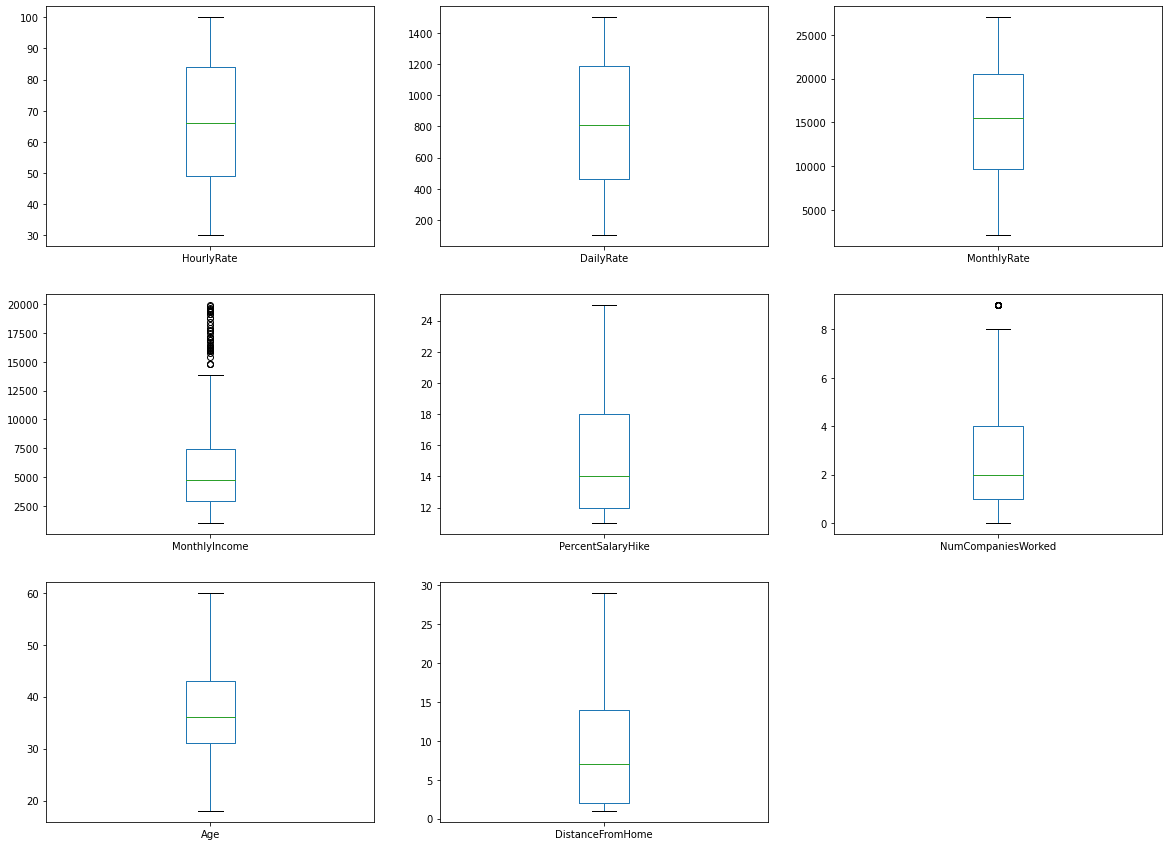

In [11096]:
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)
ax = plt.subplot2grid(fig_dims, (0, 0))
df["HourlyRate"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (0, 1))
df["DailyRate"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (0, 2))
df["MonthlyRate"].plot.box(ax=ax)

ax = plt.subplot2grid(fig_dims, (1, 0))
df["MonthlyIncome"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (1, 1))
df["PercentSalaryHike"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (1, 2))
df["NumCompaniesWorked"].plot.box(ax=ax)

ax = plt.subplot2grid(fig_dims, (2, 0))
df["Age"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (2, 1))
df["DistanceFromHome"].plot.box(ax=ax)

plt.show()

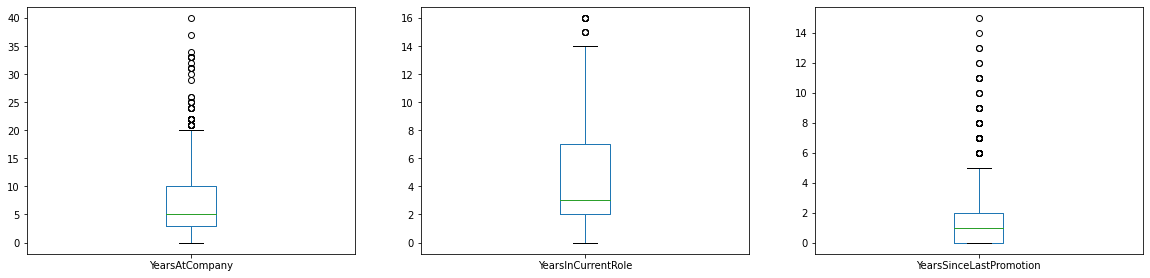

In [11097]:
fig =plt.subplots(figsize=(20, 10))
fig_dims = (2, 3)
ax = plt.subplot2grid(fig_dims, (0, 0))
df["YearsAtCompany"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (0, 1))
df["YearsInCurrentRole"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (0, 2))
df["YearsSinceLastPromotion"].plot.box(ax=ax)

plt.show()

From the above box and whisker plots we can see that <b>7 features are biased with ouliers</b>:
- MonthlyIncome
- NumCompaniesWorked
- TotalWorkingYears
- YearsAtCompany
- YearsInCurrentRole
- YearsWithCurrentManager
- YearsSinceLastPromotion

This is confirmed by the IQR, too, as shown bellow. Since some attributes are categorical (their cut-off is nearby 0, more preciselly <= 1.500) we will omitt them in the outlier detection process, since we will remove enitire category of employees belonging to one or more optionions of the categorical attribute (which already has a low value cardinality).

In [11098]:
column_names = list(df.columns)
for column_name in column_names:
    data = df[column_name].dropna()  # get each column's values, omitting NaN values 
    if isinstance(data[0], int) or isinstance(data[0], float):
        # get the outlier cutoff
        q25, q75, cut_off, lower, upper = get_interquartile_cut_off(data, 3)
        # identify outlier
        outliers = {}
        outliers["lower"] = []
        outliers["upper"] = []
        for x in data:
            if x < lower:
                tmp_list =  outliers["lower"]
                tmp_list.append(x)
                outliers["lower"] = tmp_list
            elif x > upper:
                tmp_list =  outliers["upper"]
                tmp_list.append(x)
                outliers["upper"] = tmp_list

        tot_outliers = len(outliers["lower"]) + len(outliers["upper"])
        if tot_outliers > 0 and cut_off > 1.500: # cut_off > 1.500: avoid ordinal values elimination 
            print( '%s\'s percentiles: 25th=%.3f, 75th=%.3f, cut_off=%.3f, outliers: %d' 
                            % (column_name, q25, q75, cut_off, tot_outliers))
            df = df.drop(df[df[column_name] < lower].index)  # remove employees under lower 
            df = df.drop(df[df[column_name] > upper].index)  # remove employees above upper 
        
df.shape  # checking removal output

YearsAtCompany's percentiles: 25th=3.000, 75th=10.000, cut_off=21.000, outliers: 8


(933, 30)

After the IQR outlier detection process our DataFrame results in the removal of <b>8 extreme outliers</b>.

At the end of the outlier removal process our DataSets counts 913 rows.

<h2> Type conversion</h2>

Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. This means that categorical data must be converted to a numerical form.

This ordinal encoding transform is available in the <b>scikit-learn</b> Python machine learning library via the <b>OrdinalEncoder</b> class. By default, it will assign integers to labels in alphabetical order. If a specific
order is desired, it can be specified via the <u>categories</u> argument as a list with the rank order of all expected labels.

For categorical variables where no ordinal relationship exists, the integer encoding may not be enough or even misleading to the model. Forcing an ordinal relationship via an ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results. In this case, a one
hot encoding can be applied to the ordinal representation. This is where <b>the integer encoded variable is removed and one new binary variable is added for each unique integer value in the variable</b>. This one hot encoding transform is available in the <b>scikit-learn</b> Python machine learning library via the <b>OneHotEncoder</b> class. By default, it will create new binary variables in column's values alphabetical order. If a specific
order is desired, it can be specified via the <u>categories</u> argument as a list.

<h6> Perform an integer encoding on all ordinal and nominal features (object data types)</h6>

In [11099]:
def print_encoding(column_name, encoder_categories):
    """
    Function which prints the encoding undergone
    """
    print("%s's values encoded as:" % column_name)
    for i in range(0, len(encoder_categories[0])):
        print("%s" % encoder_categories[0][i], "%d" % i, sep="\t")

In [11100]:
def replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features):
    """
    Function which replaces the nominal feature passed by argument with dummy ones, 
    to convert nominal column's M values in M new binary (dummy) features.
    """
    # retrive nominal feature's index. It is used to know where to insert the new M binary features
    index = df.columns.get_loc(column_name)
    for i in range(0, dummy_features.shape[1]):
        index += 1
        df.insert(index, column_name + "_" + str(categories_list[i].replace(" ", "_")), 
                                                              dummy_features[:, i].todense().astype(int), True)
    # remove categorical feature
    del df[column_name]

In ordert to encode our not already encoded categorical features, we have to select them. We do this by looking at all object type columns in the dataset:

In [11101]:
# select columns which are of object datatype 
df_mod = df.select_dtypes(include=['object'])
df_mod.dtypes

Attrition         object
BusinessTravel    object
Department        object
EducationField    object
Gender            object
JobRole           object
MaritalStatus     object
OverTime          object
dtype: object

Our dataset has <b>8 categorical features not already encoded</b>, sub-divided as follows:

<b> nominal features (6): </b>
- Attrition;  
- Department;
- EducationField;
- Gender;
- OverTime;
- JobRole.

<b> ordinal features (2): </b>  
- BusinessTravel;
- MaritalStatus;


Before encoding these categorical variables, however, we have to check if they have missing values, because otherwise the NaN values will be replaced, too (it is possible to explicitly avoid this, but for simplicity we will replace missing values with each column's mode).

In [11102]:
# check for any null values present in the categorical data
df_mod.isnull().sum()

Attrition          0
BusinessTravel    84
Department         0
EducationField     0
Gender            41
JobRole            0
MaritalStatus      0
OverTime           0
dtype: int64

Our dataset present 1 nominal and 1 ordinal feature with missing values, so we are going to replace all NaN values with the most common value in each column ("Travel_Rarely" for "BusinessTravel" and "Male" for "Gender", as we saw from the data distribution above):

<h6> Statistical imputation strategy </h6>

A popular approach for data imputation is to calculate a statistical value for each column (such as a mean\*/ median\*\*/ mode\*\*\*/ costant value) and replace all missing values for that column with the statistic. It is a popular approach because the statistic is easy to calculate using the training dataset and because it often results in good performance. 

\*columns' average values;<br>
\*\*middle element in ascending ordered column;<br>
\*\*\*most frequent element in column.

The <b>scikit-learn</b> machine learning library provides the <b>SimpleImputer</b> class that supports statistical imputation.
The SimpleImputer is a data transform, which needs the following parameters:
- the type of the missing values to replace via the <u>missing_values</u> argument;
- the type of statistic to calculate for each column via the <u>strategy</u> argument. 

Then, the imputer is fit on the dataset, creating a copy of the dataset with all missing values for each column replaced with an estimated value.

We will use the <b>mode imputation strategy</b> with the following feature:
- BusinessTravel;
- Gender;
- TrainingTimesLastYear;

since the first two are categorical data, while the last is a numerical attributes with low cardinality ranging from 0 to 6, so we take advantage of the statistical imputation and replace its missing values, too. We will handle the replacement taking the most common element in the column (BussinessTravel=Travel_Rarerly, Gender=Male, TrainingTimeLastYear=2), since this won't compromise any other feature in the dataset.

In [11103]:
# checking columns' missing data
column_names = list(df.columns)
for column_name in column_names:
    # count number of rows with missing values
    data = df[column_name]
    n_miss = data.isnull().sum()
    perc = n_miss / df.shape[0] * 100
    if n_miss > 0:
        print( '%s, Missing: %d (%.1f%% of rows) ' % (column_name, n_miss, perc))

Age, Missing: 138 (14.8% of rows) 
BusinessTravel, Missing: 84 (9.0% of rows) 
Gender, Missing: 41 (4.4% of rows) 
MonthlyIncome, Missing: 165 (17.7% of rows) 
TrainingTimesLastYear, Missing: 181 (19.4% of rows) 
YearsAtCompany, Missing: 49 (5.3% of rows) 
TaxRate, Missing: 165 (17.7% of rows) 


<h6>SimpleImputer imputations </h6<

In [11104]:
# replacing null values with most frequent value ('Travel_Rarely', 'Male', '2')
column_names = ["BusinessTravel", "Gender", "TrainingTimesLastYear"]
for column_name in column_names:
    # summarize total missing values
    print('%s missing before inputation: %d ' % (column_name, df[column_name].isnull().sum()))
    # define the imputer model
    imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    # fit the model on the dataset to impute its missing values and transform it
    df[column_name] = imputer.fit_transform(df[column_name].values.reshape(-1,1))[:,0]
    # summarize total missing values
    print('%s missing after inputation:: %d ' % (column_name, df[column_name].isnull().sum()))

BusinessTravel missing before inputation: 84 
BusinessTravel missing after inputation:: 0 
Gender missing before inputation: 41 
Gender missing after inputation:: 0 
TrainingTimesLastYear missing before inputation: 181 
TrainingTimesLastYear missing after inputation:: 0 


<h6> Self-made YearsAtCompany imputation </h6>

To replace NaN values in the YearsAtCompany feature, we opted to guess the missing value by:
- taking a set of correlated variables (JobRole, JobLevel, Age, YearsInCurrentRole);
- searching similar neighbours in the DataFrame:
    - first, by looking at reacords having the exact values of the features mention above and taking
      their average, mode or median YearsAtCompany, if missing record's Age - gueesed_YearsAtCompany => 16; 
    - if the previous constrains wasn't met or none record in the DataFrame shared the same values as the 
      missing one, we started to be more relaxed on the Age feature, allowing the searching of neighbours
      having an <b>Age</b> in a <b>cut_off=+-10</b> above and below missing record's Age. Again we took 
      neighbours average, mode or median YearsAtCompany, if they comply with 
      record's Age - gueesed_YearsAtCompany => 16;
    - if no neighbour was previously found, we experimented again with Age's cut_off=+-10 above and below         missing record's Age, but we drop the YearsInCurrentRole requirement;
    -  if no neighbour wasn't agein previously found, we drop the Age variabele, searching only records with exact        JobRole and JobLevel as the missing one and taking their mean, mode or median if 
       Age - gueesed_YearsAtCompany => 16.

In [11105]:
def years_at_company_imputation(jobRole, jobLevel, age, yearsInCurrentRole):
    for age_cut_off in range(1, 11):
        tmp_df = df[(df["JobRole"] == jobRole) &
                    (df["JobLevel"] == jobLevel) & 
                    (df["Age"] > (age - age_cut_off)) &
                    (df["Age"] < (age + age_cut_off)) &
                    (df["YearsInCurrentRole"] == yearsInCurrentRole)]
        
        if tmp_df.shape[0] > 1:  # at least a neighbours
            years = []
            for row in tmp_df.itertuples():
                if row.YearsAtCompany >= 0:  # this excludes NaN values
                    years.append(row.YearsAtCompany)
            
            avg_years_at_company = int(statistics.mean(years))
            med_years_at_company = int(statistics.median(years))
            mode_years_at_company = int(statistics.mode(years))
            
            # checking if Age - YearsAtCompany >= 16
            if age - avg_years_at_company >= 16:
                return avg_years_at_company
            elif age - mode_years_at_company >= 16:
                return mode_years_at_company
            elif age - med_years_at_company >= 16:
                return med_years_at_company
                
    
    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the YearsInCurrentRole constrain 
        for age_cut_off in range(1, 11):
            tmp_df = df[(df["JobRole"] == jobRole) &
                        (df["JobLevel"] == jobLevel) & 
                        (df["Age"] > (age - age_cut_off)) &
                        (df["Age"] < (age + age_cut_off))]

            if tmp_df.shape[0] > 1:  # at least a neighbours
                years = []
                for row in tmp_df.itertuples():
                    if row.YearsAtCompany >= 0:  # this excludes NaN values
                        years.append(row.YearsAtCompany)

                avg_years_at_company = int(statistics.mean(years))
                mode_years_at_company = int(statistics.mode(years))
                med_years_at_company = int(statistics.median(years))

                # checking if Age - YearsAtCompany >= 16
                if age - avg_years_at_company >= 16:
                    return avg_years_at_company
                elif age - mode_years_at_company >= 16:
                    return mode_years_at_company
                elif age - med_years_at_company >= 16:
                    return med_years_at_company
    
    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the age constrain 
        tmp_df = df[(df["JobRole"] == jobRole) &
                    (df["JobLevel"] == jobLevel)]
        
        if tmp_df.shape[0] > 1:  # at least a neighbours
            years = []
            for row in tmp_df.itertuples():
                if row.YearsAtCompany >= 0:  # this excludes NaN values
                    years.append(row.YearsAtCompany)
            
            avg_years_at_company = int(statistics.mean(years))
            mode_years_at_company = int(statistics.mode(years))
            med_years_at_company = int(statistics.median(years))
            
            # checking if age is != NaN
            if age > 0:
                # checking if Age - YearsAtCompany >= 16
                if age - avg_years_at_company >= 16:
                    return avg_years_at_company
                elif age - mode_years_at_company >= 16:
                    return mode_years_at_company
                elif age - med_years_at_company >= 16:
                    return med_years_at_company
            else:
                 return avg_years_at_company
    return -1

In [11106]:
print('%s missing before inputation: %d ' % ("YearsAtCompany", df["YearsAtCompany"].isnull().sum()))
data = []
for row in df.itertuples():
    if row.YearsAtCompany >= 0:
        data.append(row.YearsAtCompany)
    else:  # NaN value imputation 
        years_at_company = years_at_company_imputation(row.JobRole, row.JobLevel, row.Age, 
                                                                                    row.YearsInCurrentRole)
        if years_at_company == -1:
            print("missing", row.JobRole, row.JobLevel, row.Age, row.YearsInCurrentRole, row.MonthlyIncome)
        else:
            data.append(years_at_company)

# remove current column and replace it with impunted one
index = df.columns.get_loc("YearsAtCompany")
del df["YearsAtCompany"]
df.insert(index, 'YearsAtCompany', data)
print('%s missing after inputation: %d ' % ("YearsAtCompany", df["YearsAtCompany"].isnull().sum()))
df.shape 

YearsAtCompany missing before inputation: 49 
YearsAtCompany missing after inputation: 0 


(933, 30)

<h6> Self-made MonthlyIncome imputation </h6>

Since we have added the column TaxRate, MonthlyIncome imputation is performed upon it and in simultaneously with it.

We need to guess record's missing TaxRates in order to be able to compute the missing MonthlyIncome, too.
By guessing a missing TaxRates, we are able to calculate the MonthlyIncome as follows:
$$MonthlyIncome = MonthlyRate - MonthlyRate*TaxRate$$

The imputation was performed similarly to <b> Self-made YearsAtCompany imputation </b>, considering an <b>Age cut_off=+-5</b> and a <b>YearsAtCompany cut_off=+-5</b> and the features JobRole, JobLevel, YearsAtCompany, Age, TrainingTimeLastYear, PercentSalaryHike, StockOptionLevel and YearsInCurrentRole.

In [11107]:
def taxrate_imputation(jobRole, jobLevel, yearsAtCompany, age, trainingTimeLastYear, percentSalaryHike,
                                                           stockOptionLevel, yearsInCurrentRole):
    
    for age_cut_off in range(1, 6):
        for y_company_cut_off in range(1, 6):
            tmp_df = df[(df["JobRole"] == jobRole) &
                        (df["JobLevel"] == jobLevel) &
                        (df["YearsAtCompany"] > (yearsAtCompany - y_company_cut_off)) &
                        (df["YearsAtCompany"] < (yearsAtCompany + y_company_cut_off)) &
                        (df["Age"] > (age - age_cut_off)) &
                        (df["Age"] < (age + age_cut_off)) &
                        (df["TrainingTimesLastYear"] == trainingTimeLastYear) &
                        (df["PercentSalaryHike"] == percentSalaryHike) &
                        (df["StockOptionLevel"] == stockOptionLevel) &
                        (df["YearsInCurrentRole"] == yearsInCurrentRole)]

            if tmp_df.shape[0] > 1:  # at least a neighbours
                taxes = []
                for row in tmp_df.itertuples():
                    if row.TaxRate >= 0:  # this excludes NaN values
                        taxes.append(row.TaxRate)

                if len(taxes) > 0:
                    avg_tax = int(statistics.mean(taxes))
                    return avg_tax

    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the YearsInCurrentRole constrain 
    for age_cut_off in range(1, 6):
        for y_company_cut_off in range(1, 6):
            tmp_df = df[(df["JobRole"] == jobRole) &
                        (df["JobLevel"] == jobLevel) &
                        (df["YearsAtCompany"] > (yearsAtCompany - y_company_cut_off)) &
                        (df["YearsAtCompany"] < (yearsAtCompany + y_company_cut_off)) &
                        (df["Age"] > (age - age_cut_off)) &
                        (df["Age"] < (age + age_cut_off)) &
                        (df["TrainingTimesLastYear"] == trainingTimeLastYear) &
                        (df["PercentSalaryHike"] == percentSalaryHike) &
                        (df["StockOptionLevel"] == stockOptionLevel) ]

            if tmp_df.shape[0] > 1:  # at least a neighbours
                taxes = []
                for row in tmp_df.itertuples():
                    if row.TaxRate >= 0:  # this excludes NaN values
                        taxes.append(row.TaxRate)

                if len(taxes) > 0:
                    avg_tax = int(statistics.mean(taxes))
                    return avg_tax

    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the StockOptionLevel constrain 
    for age_cut_off in range(1, 6):
        for y_company_cut_off in range(1, 6):
            tmp_df = df[(df["JobRole"] == jobRole) &
                        (df["JobLevel"] == jobLevel) &
                        (df["YearsAtCompany"] > (yearsAtCompany - y_company_cut_off)) &
                        (df["YearsAtCompany"] < (yearsAtCompany + y_company_cut_off)) &
                        (df["Age"] > (age - age_cut_off)) &
                        (df["Age"] < (age + age_cut_off)) &
                        (df["TrainingTimesLastYear"] == trainingTimeLastYear) &
                        (df["PercentSalaryHike"] == percentSalaryHike)]

            if tmp_df.shape[0] > 1:  # at least a neighbours
                taxes = []
                for row in tmp_df.itertuples():
                    if row.TaxRate >= 0:  # this excludes NaN values
                        taxes.append(row.TaxRate)

                if len(taxes) > 0:
                    avg_tax = int(statistics.mean(taxes))
                    return avg_tax

    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the PercentSalaryHikeConstrain constrain 
    for age_cut_off in range(1, 6):
        for y_company_cut_off in range(1, 6):
            tmp_df = df[(df["JobRole"] == jobRole) &
                        (df["JobLevel"] == jobLevel) &
                        (df["YearsAtCompany"] > (yearsAtCompany - y_company_cut_off)) &
                        (df["YearsAtCompany"] < (yearsAtCompany + y_company_cut_off)) &
                        (df["Age"] > (age - age_cut_off)) &
                        (df["Age"] < (age + age_cut_off)) &
                        (df["TrainingTimesLastYear"] == trainingTimeLastYear)]

            if tmp_df.shape[0] > 1:  # at least a neighbours
                taxes = []
                for row in tmp_df.itertuples():
                    if row.TaxRate >= 0:  # this excludes NaN values
                        taxes.append(row.TaxRate)

                if len(taxes) > 0:
                    avg_tax = int(statistics.mean(taxes))
                    return avg_tax


    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the TrainingTimeLastYear constrain 
    for age_cut_off in range(1, 6):
        for y_company_cut_off in range(1, 6):
            tmp_df = df[(df["JobRole"] == jobRole) &
                        (df["JobLevel"] == jobLevel) &
                        (df["YearsAtCompany"] > (yearsAtCompany - y_company_cut_off)) &
                        (df["YearsAtCompany"] < (yearsAtCompany + y_company_cut_off)) &
                        (df["Age"] > (age - age_cut_off)) &
                        (df["Age"] < (age + age_cut_off))]

            if tmp_df.shape[0] > 1:  # at least a neighbours
                taxes = []
                for row in tmp_df.itertuples():
                    if row.TaxRate >= 0:  # this excludes NaN values
                        taxes.append(row.TaxRate)

                if len(taxes) > 0:
                    avg_tax = int(statistics.mean(taxes))
                    return avg_tax

    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the Age constrain
    for y_company_cut_off in range(1, 6):
        tmp_df = df[(df["JobRole"] == jobRole) &
                (df["JobLevel"] == jobLevel) &
                (df["YearsAtCompany"] > (yearsAtCompany - y_company_cut_off)) & 
                (df["YearsAtCompany"] < (yearsAtCompany + y_company_cut_off)) ]

        if tmp_df.shape[0] > 1:  # at least a neighbours
            taxes = []
            for row in tmp_df.itertuples():
                if row.TaxRate >= 0:  # this excludes NaN values
                    taxes.append(row.TaxRate)

            if len(taxes) > 0:
                avg_tax = int(statistics.mean(taxes))
                return avg_tax
    
    
    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop YearsAtCompany
    tmp_df = df[(df["JobRole"] == jobRole) &
            (df["JobLevel"] == jobLevel)]

    if tmp_df.shape[0] > 1:  # at least a neighbours
        taxes = []
        for row in tmp_df.itertuples():
            if row.TaxRate >= 0:  # this excludes NaN values
                taxes.append(row.TaxRate)

        if len(taxes) > 0:
            avg_tax = int(statistics.mean(taxes))
            return avg_tax

    return -1

In [11108]:
print('%s missing before inputation: %d ' % ("TaxRate", df["TaxRate"].isnull().sum()))
print('%s missing before inputation: %d ' % ("MonthlyIncome", df["MonthlyIncome"].isnull().sum()))
data = []
data2 = []
for row in df.itertuples():
    if row.TaxRate > 0:
        data.append(row.TaxRate)
        data2.append(row.MonthlyIncome)
    else:  # NaN value imputation 
        tax = taxrate_imputation(row.JobRole, row.JobLevel, row.YearsAtCompany, row.Age, 
            row.TrainingTimesLastYear, row.PercentSalaryHike, row.StockOptionLevel, row.YearsInCurrentRole)
        tax = round(tax, 2)
        
        if tax == -1:
            print("missing", row.JobRole, row.JobLevel, row.YearsAtCompany, row.Age, row.YearsInCurrentRole)
        else:
            data.append(tax)
            # compute MonthlyIncome
            income = row.MonthlyRate - (row.MonthlyRate*tax)
            data2.append(income)

# remove current column and replace it with impunted one
index1 = df.columns.get_loc("TaxRate")
index2 = df.columns.get_loc("MonthlyIncome")
del df["TaxRate"]
df.insert(index1, 'TaxRate', data)
del df["MonthlyIncome"]
df.insert(index2, 'MonthlyIncome', data2)
print('%s missing after inputation: %d ' % ("TaxRate", df["TaxRate"].isnull().sum()))
print('%s missing after inputation: %d ' % ("MonthlyIncome", df["MonthlyIncome"].isnull().sum()))
df.shape

TaxRate missing before inputation: 165 
MonthlyIncome missing before inputation: 165 
TaxRate missing after inputation: 0 
MonthlyIncome missing after inputation: 0 


(933, 30)

<h6> Self-made Age imputation </h6>

The imputation was performed similarly to <b> Self-made YearsAtCompany imputation </b>, considering a <b>YearsAtCompany cut_off=+-10</b> and the features JobRole, JobLevel, YearsAtCompany and YearsInCurrentRole.

We needed to remove an outlier, too: a level 2 Research Scientist, woorking in this position for 13 years, for which we didn't find any similar neighbour.

In [11109]:
def age_imputation(jobRole, jobLevel, yearsAtCompany, yearsInCurrentRole):
    for y_company_cut_off in range(1, 11):
        tmp_df = df[(df["JobRole"] == jobRole) &
                    (df["JobLevel"] == jobLevel) & 
                    (df["YearsAtCompany"] > (yearsAtCompany - y_company_cut_off)) &
                    (df["YearsAtCompany"] < (yearsAtCompany + y_company_cut_off)) &
                    (df["YearsInCurrentRole"] == yearsInCurrentRole)]
        
        if tmp_df.shape[0] > 1:  # at least a neighbours
            ages = []
            for row in tmp_df.itertuples():
                if row.Age >= 0:  # this excludes NaN values
                    ages.append(row.Age)
                    
            if len(ages) > 0:
                avg_age_at_company = int(statistics.mean(ages))
                med_age_at_company = int(statistics.median(ages))
                mode_age_at_company = int(statistics.mode(ages))

                # checking if Age - YearsAtCompany >= 16
                if avg_age_at_company - yearsAtCompany >= 16:
                    return avg_age_at_company
                elif med_age_at_company - yearsAtCompany >= 16:
                    return avg_age_at_company
                elif mode_age_at_company - yearsAtCompany >= 16:
                    return mode_age_at_company
    
    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the YearsInCurrentRole constrain 
    for y_company_cut_off in range(1, 11):
        tmp_df = df[(df["JobRole"] == jobRole) &
                    (df["JobLevel"] == jobLevel) & 
                    (df["YearsAtCompany"] > (yearsAtCompany - y_company_cut_off)) &
                    (df["YearsAtCompany"] < (yearsAtCompany + y_company_cut_off))]

        if tmp_df.shape[0] > 1:  # at least a neighbours
            ages = []
            for row in tmp_df.itertuples():
                if row.Age >= 0:  # this excludes NaN values
                    ages.append(row.Age)

            if len(ages) > 0:
                avg_age_at_company = int(statistics.mean(ages))
                med_age_at_company = int(statistics.median(ages))
                mode_age_at_company = int(statistics.mode(ages))

                # checking if Age - YearsAtCompany >= 16
                if avg_age_at_company - yearsAtCompany >= 16:
                    return avg_age_at_company
                elif med_age_at_company - yearsAtCompany >= 16:
                    return med_age_at_company
                elif mode_age_at_company - yearsAtCompany >= 16:
                    return mode_age_at_company
    
    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the yearsAtCompany constrain 
    tmp_df = df[(df["JobRole"] == jobRole) &
                (df["JobLevel"] == jobLevel)]

    if tmp_df.shape[0] > 1:  # at least a neighbours
        ages = []
        for row in tmp_df.itertuples():
            if row.Age >= 0:  # this excludes NaN values
                ages.append(row.Age)

        if len(ages) > 0:
            avg_age_at_company = int(statistics.mean(ages))
            med_age_at_company = int(statistics.median(ages))
            mode_age_at_company = int(statistics.mode(ages))

            # checking if Age - YearsAtCompany >= 16
            if avg_age_at_company - yearsAtCompany >= 16:
                return avg_age_at_company
            elif med_age_at_company - yearsAtCompany >= 16:
                return med_age_at_company
            elif mode_age_at_company - yearsAtCompany >= 16:
                return mode_age_at_company
    
        
    # if I'm here its means that I haven't found anyting to impute =>
    # I'll drop the JobLevel constrain 
    tmp_df = df[(df["JobRole"] == jobRole)]

    if tmp_df.shape[0] > 1:  # at least a neighbours
        ages = []
        for row in tmp_df.itertuples():
            if row.Age >= 0:  # this excludes NaN values
                ages.append(row.Age)

        if len(ages) > 0:
            avg_age_at_company = int(statistics.mean(ages))
            med_age_at_company = int(statistics.median(ages))
            mode_age_at_company = int(statistics.mode(ages))

            # checking if Age - YearsAtCompany >= 16
            if avg_age_at_company - yearsAtCompany >= 16:
                return avg_age_at_company
            elif med_age_at_company - yearsAtCompany >= 16:
                return med_age_at_company
            elif mode_age_at_company - yearsAtCompany >= 16:
                return mode_age_at_company
        
    # if I'm here its means that I haven't found anyting to impute =>
    # I'll take company's avg age
    ages = []
    ages.append(df["Age"].mean())

    if len(ages) > 0:
        avg_age_at_company = int(statistics.mean(ages))
        med_age_at_company = int(statistics.median(ages))
        mode_age_at_company = int(statistics.mode(ages))

        # checking if Age - YearsAtCompany >= 16
        if avg_age_at_company - yearsAtCompany >= 16:
            return avg_age_at_company
        elif med_age_at_company - yearsAtCompany >= 16:
            return med_age_at_company
        elif mode_age_at_company - yearsAtCompany >= 16:
            return mode_age_at_company
        
    return -1

In [11110]:
print('%s missing before inputation: %d ' % ("Age", df["Age"].isnull().sum()))
data = []
i = 0
for row in df.itertuples():
    if row.Age >= 0:
        data.append(row.Age)
    else:  # NaN value imputation 
        age = age_imputation(row.JobRole, row.JobLevel, row.YearsAtCompany, row.YearsInCurrentRole)
        if age == -1:
            print("missing", row.JobRole, row.JobLevel, row.YearsAtCompany,
                                                          row.YearsInCurrentRole, row.MonthlyIncome)
            # remove probable outlier
            df.drop(list([i]), axis=0, inplace=True)
            df.reset_index(drop=True, inplace=True)
            print("dropped rows = ", 1, sep="\t")
        else:
            data.append(age)
    i += 1

# remove current column and replace it with impunted one
index = df.columns.get_loc("Age")
del df["Age"]
df.insert(index, 'Age', data)
print('%s missing after inputation: %d ' % ("Age", df["Age"].isnull().sum()))
df.shape 

Age missing before inputation: 138 
missing Research Scientist 2 26.0 13 21029.0
dropped rows = 	1
Age missing after inputation: 0 


(932, 30)

<b> Encodings </b>

Since we are not sure if our DataFrame may be useful in the future without the encoded values, we will make a copy of it, before proceeding with our encoding process:

From now on we will proceed with our object values encoding, using the <b>OrdinalEncoder</b> and the <b>OneHotEncoder</b> as appropriate:

In [11111]:
# create binary encoder 
encoder = OrdinalEncoder(categories=[['No', 'Yes']])  # excplict force encoding order
# fit and transform model on data
df["Attrition"] = encoder.fit_transform(df["Attrition"].values.reshape(-1,1))[:,0].astype(int)
df["OverTime"] = encoder.fit_transform(df["OverTime"].values.reshape(-1,1))[:,0].astype(int)
print_encoding("Attrition", encoder.categories_)
print()
print_encoding("OverTime", encoder.categories_)

Attrition's values encoded as:
No	0
Yes	1

OverTime's values encoded as:
No	0
Yes	1


In [11112]:
# create binary encoder 
encoder = OrdinalEncoder(categories=[['Male', 'Female']])   # excplict force encoding order
# fit and transform model on data
df["Gender"] = encoder.fit_transform(df["Gender"].values.reshape(-1,1))[:,0].astype(int)
print_encoding("Gender", encoder.categories_)

Gender's values encoded as:
Male	0
Female	1


In [11113]:
# create ordinal encoder 
column_name = "BusinessTravel"
categories_list = ["Non-Travel", "Travel_Rarely", "Travel_Frequently"] 
encoder = OneHotEncoder(categories=[categories_list])   # excplict force encoding order
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

BusinessTravel's values encoded as:
Non-Travel	0
Travel_Rarely	1
Travel_Frequently	2


(932, 32)

In [11114]:
# create ordinary encoder 
column_name = "MaritalStatus"
categories_list = ["Single", "Married", "Divorced"]
encoder = OneHotEncoder(categories=[categories_list])   # excplict force encoding order
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

MaritalStatus's values encoded as:
Single	0
Married	1
Divorced	2


(932, 34)

In [11115]:
# create categorical encoder 
column_name = "Department"
categories_list = sorted(df[column_name].unique())
encoder = OneHotEncoder()
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

Department's values encoded as:
Human Resources	0
Research & Development	1
Sales	2


(932, 36)

In [11116]:
# create categorical encoder 
column_name = "EducationField"
categories_list = sorted(df[column_name].unique())
encoder = OneHotEncoder()
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

EducationField's values encoded as:
Human Resources	0
Life Sciences	1
Marketing	2
Medical	3
Other	4
Technical Degree	5


(932, 41)

In [11117]:
# create categorical encoder 
column_name = "JobRole"
categories_list = sorted(df[column_name].unique())
encoder = OneHotEncoder()
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

JobRole's values encoded as:
Healthcare Representative	0
Human Resources	1
Laboratory Technician	2
Manager	3
Manufacturing Director	4
Research Director	5
Research Scientist	6
Sales Executive	7
Sales Representative	8


(932, 49)

A we can see from our DataFram recap, all data object features are encoded. All our variables are int64 types, with the exection of <b>Age</b>, <b>MonthlyIncome</b>,  <b>MonthlyRate</b>, <b>TrainingTimesLastYear</b> and <b> YearsAtCompany</b> which had undergone transformations. We need to perform the convertion from int64 to float64:

<h6>Convert all float64 elements to int64 </h6>

In [11118]:
# converting float type to int
df["Age"] = df["Age"].astype(int) 
df["MonthlyIncome"] = df["MonthlyIncome"].astype(int) 
df["MonthlyRate"] = df["MonthlyRate"].astype(int)
df["TrainingTimesLastYear"] = df["TrainingTimesLastYear"].astype(int) 
df["YearsAtCompany"] = df["YearsAtCompany"].astype(int) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                932 non-null    int64  
 1   Attrition                          932 non-null    int64  
 2   BusinessTravel_Non-Travel          932 non-null    int64  
 3   BusinessTravel_Travel_Rarely       932 non-null    int64  
 4   BusinessTravel_Travel_Frequently   932 non-null    int64  
 5   DailyRate                          932 non-null    int64  
 6   Department_Human_Resources         932 non-null    int64  
 7   Department_Research_&_Development  932 non-null    int64  
 8   Department_Sales                   932 non-null    int64  
 9   DistanceFromHome                   932 non-null    int64  
 10  Education                          932 non-null    int64  
 11  EducationField_Human_Resources     932 non-null    int64  

All our feature now are int64, with the exception of <b>TaxRate</b>.

<h2> Dimensionality Reduction (Part 2)</h2>
In this section we will remove redundant features using correlation.

<h6> Data Normalization </h6>

Many machine learning algorithms perform better when numerical input variables are scaled to a standard range, since the scale and distribution of dataset's data may be different for each variable.This difference in scale for input variables does not affect all machine learning algorithms. For example, algorithms that fit a model that use a weighted sum of input variables or distance measures between examples are affected, such as k-nearest neighbors and support vector machines. There are also algorithms that are unaffected by the scale of numerical input variables, most notably decision trees and ensembles of trees, like
random forest.


The two most popular techniques for scaling numerical data prior to modeling are <b>normalization</b> and <b>standardization</b>. Since our dataset doesn't contain Gaussian distributed feature we will normalize it.

Normalization is a rescaling of the data from the original range so that all values are within the
new range of 0 and 1. A value is normalized as follows:
$$y = \dfrac{x - min}{max - min}$$
where the minimum and maximum values pertain to the value x being normalized.

The <b>scikit-learn</b> machine learning library provides the <b>MinMaxScaler</b> class that supports data normalisation. The default scale for the MinMaxScaler is to rescale variables into the range \[0, 1\], although
a preferred scale can be specified via the <u>feature_range</u> argument as a tuple containing the
min and the max for all variables. If needed, the transform can be inverted (this is useful for converting predictions back into their original scale), this can be done by calling the <b>inverse_transform()</b>
function.

In [11119]:
df_norm = df.copy()  # make a copy of the DataFrame to perform normalisation on it

In [11120]:
# for column_name in columns_to_normalize:
column_names = list(df.columns)
for column_name in column_names:
    # data = df[column_name].fillna(-1)  # convert NaN values to integers (-1) 
    data = df_norm[column_name]
    # define the scaler model
    scaler = MinMaxScaler()
    # fit the model on the feature to normale its values and transform it
    df_norm[column_name] = scaler.fit_transform(df_norm[column_name].values.reshape(-1,1))[:, 0]
# normalized input variable's summarry
df_norm.describe()  

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DailyRate,Department_Human_Resources,Department_Research_&_Development,Department_Sales,DistanceFromHome,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,TaxRate,OverallSatisfaction
count,932.00,932.00,932.00,932.00,932.00,932.00,932.00,932.00,932.00,932.00,...,932.00,932.00,932.00,932.00,932.00,932.00,932.00,932.00,932.00,932.00
mean,0.46,0.17,0.10,0.74,0.16,0.51,0.04,0.66,0.30,0.30,...,0.30,0.57,0.26,0.48,0.59,0.23,0.25,0.10,0.48,0.44
std,0.20,0.37,0.30,0.44,0.37,0.29,0.19,0.47,0.46,0.29,...,0.26,0.36,0.29,0.19,0.24,0.18,0.22,0.16,0.34,0.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.31,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.04,...,0.07,0.33,0.00,0.33,0.33,0.10,0.12,0.00,0.14,0.33
50%,0.43,0.00,0.00,1.00,0.00,0.51,0.00,1.00,0.00,0.21,...,0.21,0.67,0.33,0.50,0.67,0.16,0.19,0.07,0.54,0.33
75%,0.60,0.00,0.00,1.00,0.00,0.77,0.00,1.00,1.00,0.46,...,0.50,1.00,0.33,0.50,0.67,0.30,0.44,0.13,0.80,0.67
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [11121]:
# check if normalisation was performed well
column_names = list(df.columns)
for column_name in column_names:
    data = df_norm[column_name]
    d_min = min(data)
    d_max = max(data)
    d_std = np.std(data)

    if d_min != 0:
        print("min %f error %s" % (d_min, column_name))

    if d_max < 0.99 or d_max > 1.01:  # handle overlow errors
        print("max %f error %s" % (d_max, column_name))

    if d_std >= 1.0:
        print("std %f error %s" % (d_std, column_name))

We can see that the distributions have been adjusted and that the minimum and maximum values for categorical or numerical variables are now a crisp 0.0 and 1.0 respectively.

<h6>Correlations</h6>

In [11122]:
def draw_sns_heatmap(correlation_matrix, h_neg, h_pos, title, pngfile):
    """
    Function which draws a seaborn' heatmap based on the correlation matrix passed by argument
    """
    # generate a mask for the upper triangle
    mask = np.zeros_like(correlation_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 14))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg, h_pos, as_cmap=True)
    
    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)

    # save figure
    fig.savefig(plot_directory + pngfile)

<h6> Person correlation coefficient </h6> <br>
$$\rho_{xy} = \dfrac{Cov(x, y)}{\sigma_{x}, \sigma_{y}}$$ <br>
where: <br>
- $Cov(x, y)$ is the covariance between variable x and y; <br>
- $\sigma_{x}$ and $\sigma_{y}$ are variables' standard deviations. <br>

Values always range between -1 (strong negative relationship) and +1 (strong positive relationship). Values at or close to zero imply weak or no linear relationship.

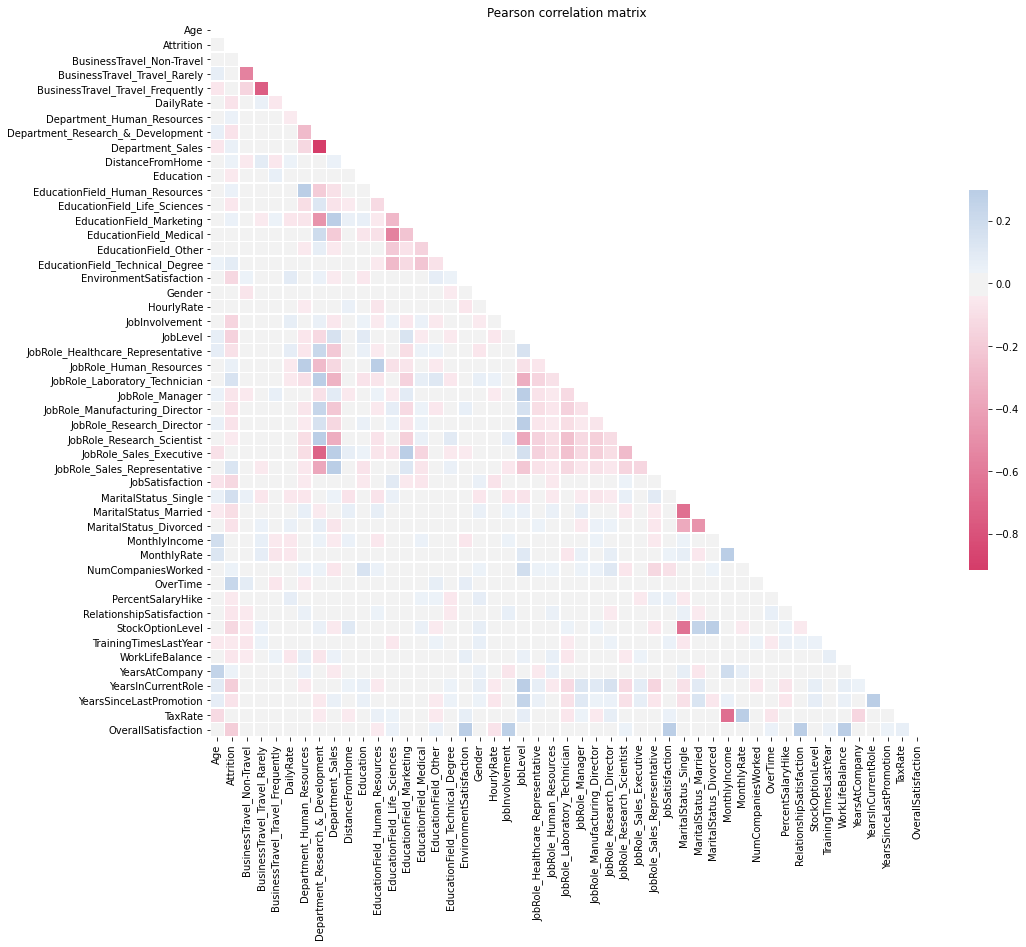

In [11123]:
# compute the correlation matrix, excluding NA/null values
correlation_matrix = df_norm.corr("pearson")  # pearson correlation
# draw heatmap
draw_sns_heatmap(correlation_matrix, 0, 250, "Pearson correlation matrix", "pearson_correlation_matrix.png")

<h6> Pearson correlation investigation </h6>
Since "Pearson", "Spearman" and "Kendall"'s correlations are equivalent, we will stick with <b>Pearson correlation</b> in our dimensional reduction process. In particular we will remove columns highly correlated given a <b>threshold equal to |0.5|</b>: 

In [11124]:
# investigating positive correlation
threshold = 0.5
corr_matrix = df.corr("pearson")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold):
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])

EducationField_Human_Resources Department_Human_Resources 0.6800121431824039
EducationField_Marketing Department_Sales 0.5174575805272599
JobRole_Human_Resources Department_Human_Resources 0.9707425017489446
JobRole_Human_Resources EducationField_Human_Resources 0.6149743172652397
JobRole_Manager JobLevel 0.5439568202094456
JobRole_Sales_Executive Department_Sales 0.7809364356733876
YearsSinceLastPromotion YearsInCurrentRole 0.6375455128379862


In [11125]:
# investigating negative correlation
threshold = -0.5
corr_matrix = df.corr("pearson")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] <= threshold):
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])

BusinessTravel_Travel_Rarely BusinessTravel_Non-Travel -0.5572636879882301
BusinessTravel_Travel_Frequently BusinessTravel_Travel_Rarely -0.7404051499493045
Department_Sales Department_Research_&_Development -0.9152473949180232
EducationField_Medical EducationField_Life_Sciences -0.5583884467318071
JobRole_Sales_Executive Department_Research_&_Development -0.714750038346652
MaritalStatus_Married MaritalStatus_Single -0.6498758790314967
StockOptionLevel MaritalStatus_Single -0.6367728000128947
TaxRate MonthlyIncome -0.65537138619105


From the Pearson correlation we found out that we can <b>remove</b> <b>"MaritalStatus"</b>, <b>"EducationField"</b>, <b>"YearsSinceLastPromotion"</b> features which are correlated and so implictly encode in "StockOptionLevel"\*, "JobRole", "YearsInCurrentRole" features. 

Regarding the <b>"Department"</b> features, they are positive correlated with <b>"JobRole"</b>, but we decided not to remove them immediatly, since we will loose Managers' belonging department. Differently from the other jobroles, in fact, "JobRole_Manager" doesn't encode in its name the department field in which a manager operates, so before removing the three onehot encoded "Department" features we need to extend the onehot encoded "JobRole_Manager" feature with its belonging department. In doing so, we will <b>replace the "JobRole_Manager" feature with</b> three new binary features:

- <b>"JobRole_Manager_Research_&_Development"</b>;
- <b>"JobRole_Manager_Human_Resources"</b>;
- <b>"JobRole_Manager_Sales"</b>. 

Then we can proceed to eliminate the three onehot encoded "Department" features.

We adopt this solution since we could free us from one variable: having the above binary variables, 
replaced the intial four binary variables "JobRole_Manager", "Department_Research_&_Development", "Department_Human_Resources" and "Department_Sales".

\*  StockOptionLevel is granted to married/divorced employees

In [11126]:
# get "JobRole_Manager" index to know where to insert the 3 new features
jobrole_manager_index = df.columns.get_loc("JobRole_Manager")
data1 = []
data2 = []
data3 = []

# create the 3 new features
for row in df_norm[["Department_Research_&_Development", "Department_Sales",
                                           "Department_Human_Resources", "JobRole_Manager"]].itertuples():
    if row.JobRole_Manager == 1:
        if row.Department_Sales == 1:
            data1.append(0)
            data2.append(1)
            data3.append(0)
        elif row.Department_Human_Resources == 1:
            data1.append(0)
            data2.append(0)
            data3.append(1)
        else:
            data1.append(1)
            data2.append(0)
            data3.append(0)
    else:
        data1.append(0)
        data2.append(0)
        data3.append(0)

# # insert new columns in normalized DataFrame
df_norm.insert(jobrole_manager_index, 'JobRole_Manager_Human_Resources', data3)
df_norm.insert(jobrole_manager_index, 'JobRole_Manager_Sales', data2)
df_norm.insert(jobrole_manager_index, 'JobRole_Manager_Research_&_Development', data1)

# insert new columns in original DataFrame, too
df.insert(jobrole_manager_index, 'JobRole_Manager_Human_Resources', data3)
df.insert(jobrole_manager_index, 'JobRole_Manager_Sales', data2)
df.insert(jobrole_manager_index, 'JobRole_Manager_Research_&_Development', data1)

# check insertion output
print(df_norm.shape)
print(df.shape)

(932, 52)
(932, 52)


<h6> Highly correlated features dropping </h6>

In [9928]:
to_drop = ["JobRole_Manager", "Department_Research_&_Development", "Department_Sales",
           "Department_Human_Resources","MaritalStatus_Single", "EducationField_Human_Resources", 
           "EducationField_Life_Sciences","EducationField_Marketing", 
           "EducationField_Medical", "EducationField_Other", "EducationField_Technical_Degree",
           "MaritalStatus_Married", "MaritalStatus_Divorced", "YearsSinceLastPromotion"]


# drop features 
for column_name in to_drop:
    del df[column_name]
    del df_norm[column_name]

# check dropping output
print(df.shape)
print(df_norm.shape)

(913, 38)
(913, 38)


@TODO decidere se tenere MonthlyIncome o TaxRate
@TODO investigare se posso derivare HourlyRate e DailyRate da MonthlyRate e TaxRate (nel caso si, allora posso eliminare le prime 2 features)